In [37]:
#Importacion de librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

#Ajustes generales
torch.backends.cudnn.deterministic = True
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Usas GPU si esta disponible
print(f'Usando dispositivo: {DEVICE}')

Usando dispositivo: cuda


In [2]:
#Filtrado de datos
#El datset ya esta casi limpio, solo hay que eliminar las filas con valores nulos y ajustar los indices

#Lectura del dataset ya descargador y descomprimido
df = pd.read_csv("./Datasets/star_classification.csv")

df = df.dropna(subset=['u','g','r','i','z','redshift','class'])
df.reset_index(drop=True, inplace=True)

#Mostrar resultados
print(f'Dimensiones finales {df.shape}')
df.head()

Dimensiones finales (100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
#Preparacion de datos, para el modelo de clasificación

#Seleccionar caracteristicas y objetivo (útiles para el modelo)
#Seleccionamos solo features numéricas
features = df.loc[:, ['u','g','r','i','z','redshift']]
targets = df.loc[:,'class']  # Etiqueta de clase (objetivo)

# Estandarizar características
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Codificar etiquetas de salida
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(targets)

print(f'Caracteristicas transformadas: {X.shape}, Objetivos: {y.shape}')

Caracteristicas transformadas: (100000, 6), Objetivos: (100000,)


In [4]:
#Dividir los datos en datos de entrenamiento, validacion y testeo
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print(f'Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')

Train set: (60000, 6), Validation set: (20000, 6), Test set: (20000, 6)


In [5]:
#Creacion de los datasets y dataloaders de pytorch
class MeteoriteDatset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = MeteoriteDatset(X_train, y_train)
val_dataset = MeteoriteDatset(X_val, y_val)
test_dataset = MeteoriteDatset(X_test, y_test)

#Creacion de los dataloaders
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
#Creación de un modelo de red neuronal
#Definición de la arquitectura de la red neuronal para clasificación
class MeteiriteModule(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Capa de entrada totalmente conectada
            nn.Linear(input_dim, 256),
            nn.ReLU(),  #Activación no lineal
            nn.BatchNorm1d(256),  #Normalización por lotes para estabilidad
            nn.Dropout(0.3),  #Regularización para evitar overfitting
            
            #Segunda capa oculta
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            #Tercera capa oculta
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            # Capa de salida
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        #Propagación hacia adelante
        return self.model(x)
    
    def predict(self, x):
        #Método para predecir etiquetas a partir de los logits
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            preds = torch.argmax(logits, dim=1)
        return preds

#Inicializar modelo
input_dim = X_train.shape[1]
output_dim = len(set(y))
model = MeteiriteModule(input_dim, output_dim).to(DEVICE)
model

MeteiriteModule(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [7]:
#Definir optimizador y funcion de perdida
loss_fn = nn.CrossEntropyLoss() #aplica log_softmax y nll_loss
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
#Funcion de entrenamiento y validacion
model.to(DEVICE)
def train_model(model, train_dl, val_dl, loss_fn, optimizer, epochs=120):
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        # ----- Entrenamiento -----
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad() #limpiar gradientes
            logits = model(x_batch) #forward pass
            loss = loss_fn(logits, y_batch) #calcular perdida
            loss.backward() #backward pass
            optimizer.step() #actualizar pesos

            #Acumular perdida y aciertos
            epoch_loss += loss.item() * x_batch.size(0)
            correct += (logits.argmax(1) == y_batch).sum().item() #aciertos
            total += y_batch.size(0)

        train_losses.append(epoch_loss / total)
        train_accuracies.append(correct / total)

        # ----- Validación -----
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad(): #no calcular gradientes
            for x_batch, y_batch in val_dl:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                logits = model(x_batch)
                loss = loss_fn(logits, y_batch)

                val_loss += loss.item() * x_batch.size(0)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

        # ----- Print cada 20 epochs -----
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} | "
                  f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

#Entrenar el modelo
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_dl, val_dl, loss_fn, optimizer, epochs=100)

Epoch 10/100 | Train Loss: 0.1206, Train Acc: 0.9637 | Val Loss: 0.1204, Val Acc: 0.9663
Epoch 20/100 | Train Loss: 0.1233, Train Acc: 0.9629 | Val Loss: 0.1154, Val Acc: 0.9697
Epoch 30/100 | Train Loss: 0.1120, Train Acc: 0.9676 | Val Loss: 0.1009, Val Acc: 0.9692
Epoch 40/100 | Train Loss: 0.1124, Train Acc: 0.9670 | Val Loss: 0.0952, Val Acc: 0.9721
Epoch 50/100 | Train Loss: 0.1141, Train Acc: 0.9660 | Val Loss: 0.0977, Val Acc: 0.9712
Epoch 60/100 | Train Loss: 0.1126, Train Acc: 0.9667 | Val Loss: 0.0965, Val Acc: 0.9716
Epoch 70/100 | Train Loss: 0.1067, Train Acc: 0.9688 | Val Loss: 0.0941, Val Acc: 0.9719
Epoch 80/100 | Train Loss: 0.1143, Train Acc: 0.9668 | Val Loss: 0.0962, Val Acc: 0.9715
Epoch 90/100 | Train Loss: 0.1080, Train Acc: 0.9688 | Val Loss: 0.0947, Val Acc: 0.9721
Epoch 100/100 | Train Loss: 0.1069, Train Acc: 0.9693 | Val Loss: 0.0935, Val Acc: 0.9730


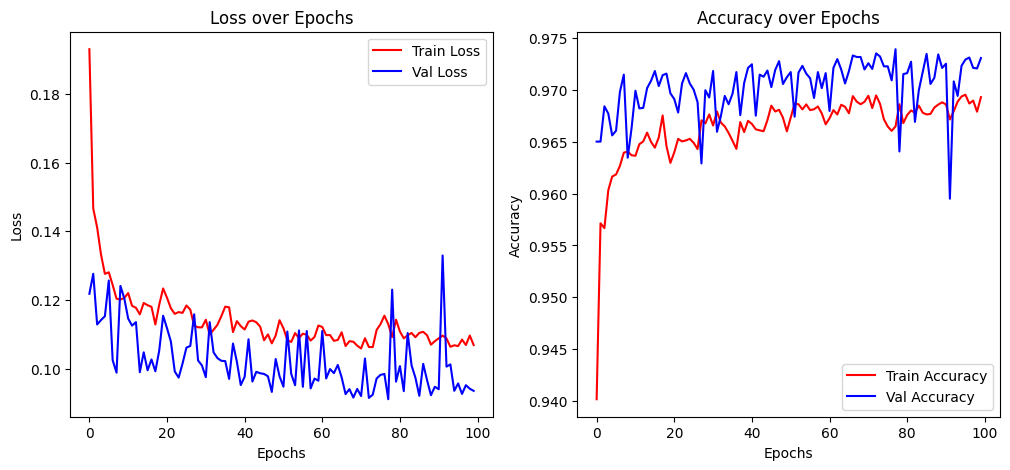

In [ ]:
#Mostrar graficas de perdida y accuracy tanto de entrenamiento como de validacion
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Val Loss', color='blue')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='red')
plt.plot(val_accuracies, label='Val Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [12]:
# Explicación de los resultados de las dos gráficas

print("La primera gráfica muestra la evolución de la función de pérdida (loss) tanto en entrenamiento como en validación a lo largo de las épocas. "
    "Podemos observar que ambas curvas descienden rápidamente al inicio y luego se estabilizan, lo que indica que el modelo está aprendiendo correctamente "
    "y no hay señales claras de sobreajuste (overfitting), ya que la pérdida de validación no aumenta significativamente.\n")

print("La segunda gráfica representa la precisión (accuracy) en entrenamiento y validación durante las épocas. "
    "Ambas curvas alcanzan valores altos y se mantienen cercanas entre sí, lo que sugiere que el modelo generaliza bien y no está memorizando los datos de entrenamiento. "
    "En resumen, el modelo logra un buen desempeño tanto en los datos de entrenamiento como en los de validación.")

La primera gráfica muestra la evolución de la función de pérdida (loss) tanto en entrenamiento como en validación a lo largo de las épocas. Podemos observar que ambas curvas descienden rápidamente al inicio y luego se estabilizan, lo que indica que el modelo está aprendiendo correctamente y no hay señales claras de sobreajuste (overfitting), ya que la pérdida de validación no aumenta significativamente.

La segunda gráfica representa la precisión (accuracy) en entrenamiento y validación durante las épocas. Ambas curvas alcanzan valores altos y se mantienen cercanas entre sí, lo que sugiere que el modelo generaliza bien y no está memorizando los datos de entrenamiento. En resumen, el modelo logra un buen desempeño tanto en los datos de entrenamiento como en los de validación.


In [9]:
#Testear el modelo
model.eval()
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        
        logits = model(x_batch)
        preds = logits.argmax(1)
        
        # Guardar predicciones y etiquetas reales
        all_preds.append(preds.cpu())
        all_labels.append(y_batch.cpu())
        
        # Calcular accuracy
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)

# Concatenar todos los batches
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

test_accuracy = test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.4f}")




Test Accuracy: 0.9715


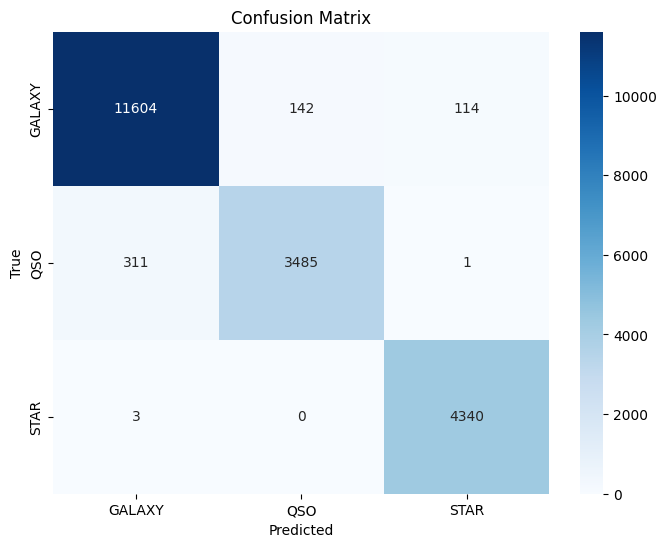

Classification Report:
               precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     11860
         QSO       0.96      0.92      0.94      3797
        STAR       0.97      1.00      0.99      4343

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Galaxy correct: 11604, Galaxy incorrect: 256


In [35]:
#Evaluacion detallada del modelo

#Creacion de matriz de confision 

target_pred = all_preds.numpy()
target_real = all_labels.numpy()

# Matriz de confusión
cm = confusion_matrix(target_real, target_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Reporte de clasificación
report = classification_report(target_real, target_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

galaxy_corr = 0
galaxy_fail = 0
for (x, y) in zip(target_pred, target_real):
    if label_encoder.inverse_transform([y])[0] == 'GALAXY':
        if (x == y):
           galaxy_corr += 1 
        else:
            galaxy_fail += 1

print(f'Galaxy correct: {galaxy_corr}, Galaxy incorrect: {galaxy_fail}')



In [ ]:
<!-- La matriz de confusión muestra el desempeño del modelo clasificando las tres clases: GALAXY, QSO y STAR. Cada fila representa la clase real y cada columna la clase predicha. Los valores en la diagonal principal (11604, 3485, 4340) indican la cantidad de ejemplos correctamente clasificados para cada clase. Los valores fuera de la diagonal representan errores de clasificación, es decir, instancias que fueron asignadas a una clase incorrecta.

En este caso, la mayoría de las predicciones están en la diagonal, lo que indica un alto nivel de precisión. Por ejemplo, de 11,860 galaxias reales, 11,604 fueron clasificadas correctamente y solo unas pocas se confundieron con QSO o STAR. De manera similar, la clase STAR tiene una tasa de acierto casi perfecta. Los errores más frecuentes ocurren entre GALAXY y QSO, lo cual es común en problemas astronómicos debido a la similitud de sus características espectrales.

En resumen, el modelo distingue muy bien entre las clases, con muy pocos errores de confusión, lo que se refleja en la alta precisión y recall observados en el reporte de clasificación. -->



In [38]:
#Guardar el modelo y parametros

torch.save(model.state_dict(), 'stellar_classification_model.pth')

#Guardar transformadores y lable encoder
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)